### The code has requests for the user. You can enter the data manually or run an auto random selection. If you want, you can input the coverage percentage anyway. 

In [1]:
auto = True  # for auto random selection write True

In [2]:
if auto:
    coverage = 30
else:
    coverage = int(input('Enter the minimum coverage percentage (non-inclusive): '))

# Task 1: Grid Representation
Create a class CityGrid that can represent the city as an N x M grid. During the initialization of the class, obstructed blocks are randomly placed with coverage >30% (we can change this parameter).

In [3]:
N, M = 30, 30

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

class CityGrid:
    def __init__(self, N, M, coverage):
        """
        Initializes the CityGrid with a grid of size n x m.
        Obstructed blocks are randomly placed with a coverage percentage.

        :param N: Number of rows in the grid.
        :param M: Number of columns in the grid.
        :param coverage: Percentage of grid to be covered with obstructions.
        """
        self.N = N
        self.M = M
        self.grid = [[0 for i in range(M)] for i in range(N)]  # 0 for open
        self.place_obstructions(coverage)
        self.towers = []

    def place_obstructions(self, coverage):
        """
        Randomly places obstructions in the grid.

        :param coverage: Min percentage of grid to be covered with obstructions (non-inclusive).
        """
        total_blocks = self.N * self.M
        obstructed_blocks = total_blocks * random.randint(coverage + 1, 80) // 100
        print(f'Number of blocks covered with obstructions {obstructed_blocks} out of total {total_blocks}')

        while obstructed_blocks > 0:
            i = random.randint(0, self.N - 1)
            j = random.randint(0, self.M - 1)
            if self.grid[i][j] == 0:  
                self.grid[i][j] = 1  # 1 for obstructed
                obstructed_blocks -= 1

    def display(self, path = None):
        """
        Displays the city grid.
        """
        numeric_grid = np.array([[i for i in row] for row in self.grid])
        colors = ['white', 'yellow', 'coral', 'darkred']  
        cmap = mcolors.ListedColormap(colors)

        plt.figure()
        plt.imshow(numeric_grid, cmap=cmap, clim=(0, 3), interpolation='nearest')
        plt.colorbar(label='Status', ticks=[0, 1, 2, 3], 
                     format=plt.FuncFormatter(lambda val, loc: {0: 'Open', 1: 'Obstructed', 2: 'Tower Coverage', 3: 'Tower'}[val]))
        plt.title("City Grid Visualization")
        plt.xticks(np.arange(0, self.M, 1), fontsize=5)
        plt.yticks(np.arange(0, self.N, 1), fontsize=5)
        plt.ylabel('row', fontsize=10)
        plt.xlabel('column', fontsize=10)
        plt.gca().set_xticks(np.arange(-0.5, self.M-0.5, 1), minor=True)
        plt.gca().set_yticks(np.arange(-0.5, self.N-0.5, 1), minor=True)
        plt.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
        plt.autoscale(enable=True, axis='both')
        
        if path:
            x_coords, y_coords = zip(*path)  # Разделение координат на x и y
            plt.plot(y_coords, x_coords, color='blue', linewidth=2, marker='o')  # Отрисовка пути

        plt.show()


Number of blocks covered with obstructions 450 out of total 900


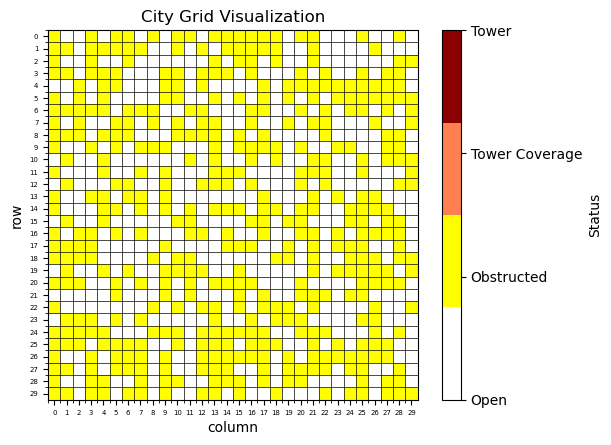

In [5]:
city = CityGrid(N, M, coverage)
city.display()

import copy
original_city = copy.deepcopy(city)

# Task 2: Tower Coverage
Each tower has a fixed range R (in blocks) within which it provides coverage. This coverage is a square, with the tower in the center.
Implement a method in the CityGrid class to place a tower and visualize its coverage.

In [6]:
def place_tower(self, i, j, R):
    """
    Tower coverage.
    :param (i, j): The row and column indices where the tower will be placed.
    :param R: The range of the tower. The coverage area is a square with sides of length 2*R+1, 
    ensuring the tower is at the center.
    """
    for x in range(max(0, i - R), min(self.N, i + R + 1)):
        for y in range(max(0, j - R), min(self.M, j + R + 1)):
            if self.grid[x][y] != 1 and self.grid[x][y] != 3:  # Do not override obstructions and towers
                self.grid[x][y] = 2  # 2 for tower coverage
    self.grid[i][j] = 3  # 3 for the tower 

def range_input(N, M, auto = False):
    if auto:
        R = random.randint(3, min(N, M)//5)
        print('Automatically selected range is', R)
        return R
    while True:
        try:
            R = int(input('Enter the range of the tower: '))
            if R > 0 and R <= N and R <= M:
                return R
            elif R < 0:
                print("Please enter a positive integer.")
            elif R > N or R > M:
                print("Please enter a possible for the grid integer.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

    
def coordinates_input(N, M, title = None, auto = False):
    if auto:
        x, y = random.randint(0, N-1), random.randint(0, M-1)
        print(f'Coordinates row x column are {x, y}')
        return x, y
    while True:
        title_str = f'{title} ' if title else ''
        c = input(f'Enter the coordinates for the {title_str}tower\n(format: row, column and size 0 <= row < {N}, 0 <= column < {M}): ')
        try:
            x, y = map(int, c.split(','))
            if 0 <= x < N and 0 <= y < M:
                return x, y
            else:
                print(f"Invalid coordinates. Please enter coordinates within the grid size: 0 <= row < {N}, 0 <= column < {M}:")
        except ValueError:
            print("Invalid input. Please enter coordinates in the format: x,y with integer values.")

Automatically selected range is 6
Coordinates row x column are (8, 11)


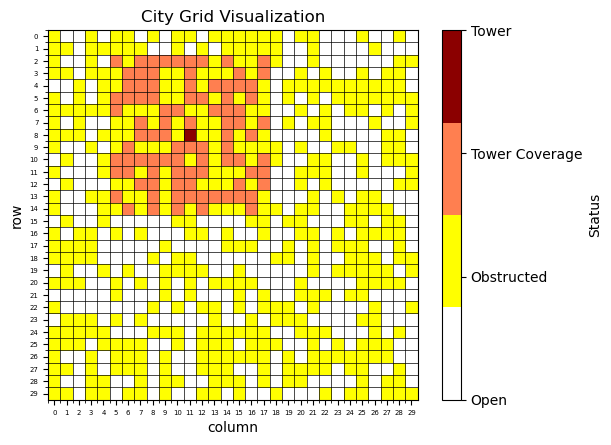

In [7]:
CityGrid.place_tower = place_tower

R = range_input(N, M, auto)
coordinates = coordinates_input(N, M, 'one', auto)
city.place_tower(*coordinates, R)  
city.display()

# Task 3: Optimization Problem
Design an algorithm to place the minimum number of towers such that all of non-obstructed blocks are within the coverage of at least one tower. The algorithm cannot place towers on obstructed blocks.
Implement a method in the CityGrid class to display the placement of towers.


In [8]:
def optimize_tower_placement(self, R):
    covered = set()
    towers = [] 

    def calculate_coverage(x, y, R):
        coverage = set()
        for i in range(max(0, x - R), min(self.N, x + R + 1)):
            for j in range(max(0, y - R), min(self.M, y + R + 1)):
                if self.grid[i][j] != 1:  # Include non-obstructed cells only
                    coverage.add((i, j))
        return coverage

    for i in range(self.N):
        for j in range(self.M):
            if self.grid[i][j] != 1 and (i, j) not in covered:
                max_coverage = set()
                best_pos = None
                for di in range(-R, R + 1):
                    for dj in range(-R, R + 1):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < self.N and 0 <= nj < self.M and self.grid[ni][nj] != 1:
                            coverage = calculate_coverage(ni, nj, R)
                            uncovered_coverage = coverage - covered
                            if len(uncovered_coverage) > len(max_coverage):
                                max_coverage = uncovered_coverage
                                best_pos = (ni, nj)

                if best_pos:
                    towers.append(best_pos)
                    covered.update(max_coverage)

    self.towers = towers
    for tower in towers:
        self.place_tower(*tower, R)

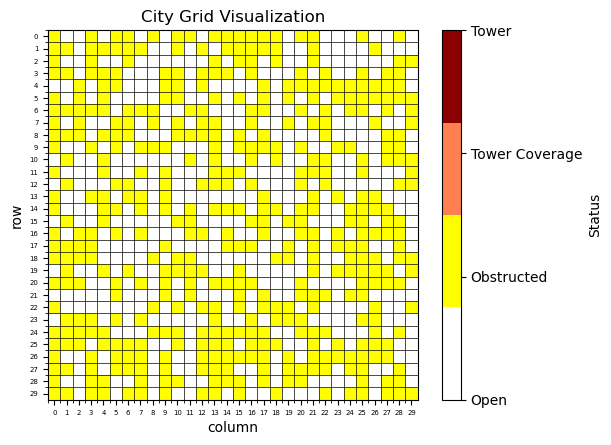

City with towers:


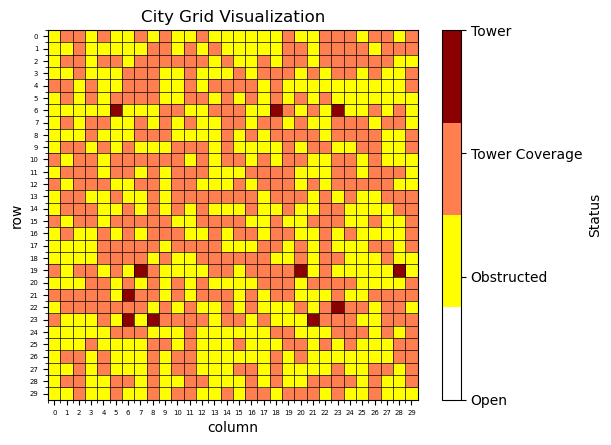

In [9]:
original_city.display()
city = original_city
original_city = copy.deepcopy(city)

CityGrid.optimize_tower_placement = optimize_tower_placement
city.optimize_tower_placement(R)
print('City with towers:')
city.display()

# Task 4: Path Reliability
Imagine that data is transmitted between towers. For simplicity, assume that each tower can directly communicate with any other tower within its range.
Design an algorithm to find the most reliable path between two towers. The reliability of a path decreases with the number of hops (tower-to-tower links). So, a path with fewer hops is more reliable.

In [10]:
def choose_towers(N, M, graph, auto=False):
    existing_towers = set(tower for tower, _ in graph.items())
    if auto:
        neighbor_pairs = [(tower, neighbor) for tower, neighbors in graph.items() for neighbor in neighbors]
        if neighbor_pairs:
            start, end = random.choice(neighbor_pairs)
            print(f"Automatically selected start tower: {start}")
            print(f"Automatically selected end tower: {end}")
            return start, end
        else:
            print("No neighboring towers found.")
            return None, None
    else:
        print('To simplify the choice of towers for communication between them')
        for tower, neighbors in graph.items():
            if neighbors:
                print(f"{tower}: {neighbors}")
            else:
                print(f"{tower}: No neighbors (no connections)")

        while True:
            start = coordinates_input(N, M, 'start')
            if start in existing_towers:
                break
            else:
                print("Invalid start tower. Please choose an existing tower.")

        while True:
            end = coordinates_input(N, M, 'end')
            if end in existing_towers:
                break
            else:
                print("Invalid end tower. Please choose an existing tower.")
        return start, end


from collections import deque

def find_reliable_path(self, R, N, M, auto=False):
    """Find the most reliable path (fewest hops) between two towers."""
    towers = self.towers
    graph = {tower: [] for tower in towers}

    for tower in towers:
        i, j = tower
        for x in range(max(0, i - R), min(self.N, i + R + 1)):
            for y in range(max(0, j - R), min(self.M, j + R + 1)):
                if (x, y) != tower and (x, y) in towers:
                    graph[tower].append((x, y))
                    
    start, end = choose_towers(N, M, graph, auto)
    
    if start is None or end is None:
        print("Start or end tower is not defined. Skipping path search.")
        return None
    
    visited = set()
    queue = deque([(start, [])]) 

    while queue:
        current, path = queue.popleft()
        if current == end:
            return path + [end]

        if current not in visited:
            visited.add(current)
            for neighbor in graph.get(current, []):
                if neighbor not in visited:
                    queue.append((neighbor, path + [current]))

if there is no path below you can replay this cell as many times as you want and then play all cells below

In [11]:
CityGrid.find_reliable_path = find_reliable_path

path = city.find_reliable_path(R, N, M, auto)
print('Most reliable path:', path)

Automatically selected start tower: (19, 7)
Automatically selected end tower: (23, 6)
Most reliable path: [(19, 7), (23, 6)]


# Task 5: Visualization
Implement functions to visualize the CityGrid, including obstructed blocks, towers, coverage areas, and data paths.
Use any Python plotting library of your choice, such as matplotlib or seaborn.

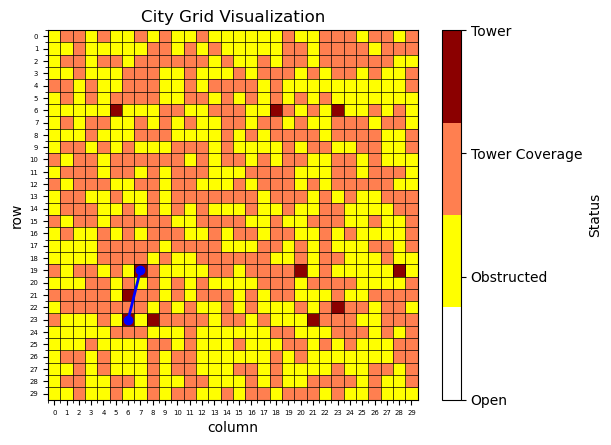

In [12]:
city.display(path)

# Bonus tasks (optional):
## 1. Extend the optimization problem: 
Now towers have a cost, and you have a limited budget. Modify your algorithm to maximize coverage while staying within the budget.

In [13]:
def optimize_tower_placement_with_limited_budget(self, R, tower_cost, budget):
    covered = set()
    added_positions = set()
    total_cost = 0 
    new_way = False
    towers = self.towers

    # Check if all towers are in the budget
    for tower in towers:
        # Check if adding this tower exceeds the budget
        if total_cost + tower_cost <= budget:
            total_cost += tower_cost
        else:
            # Break if it out the budget
            new_way = True
            break
        
    if not new_way: 
        print('\nThe budget is enough')
            
    def calculate_coverage(x, y, R):
        coverage = set()
        for i in range(max(0, x - R), min(self.N, x + R + 1)):
            for j in range(max(0, y - R), min(self.M, y + R + 1)):
                if self.grid[i][j] != 1:  # Include non-obstructed cells only
                    coverage.add((i, j))
        return coverage

    def is_tower_within_city_limits(x, y, R):
        # Check if the tower is far enough from the city edges
        return R <= x <= self.N - R and R <= y <= self.M - R

    def is_coverage_overlapping(coverage):
        # Check if the coverage overlaps with already covered areas
        return not coverage.isdisjoint(covered)

    # Calculate new way to build towers 
    if new_way:
        print('\nNeed to review the city grid for towers')
        
        # Fist phase where all towers coverages are in the cite and don't cross each other
        towers = []
        potential_towers = []
        total_cost = 0
        for i in range(self.N):
            for j in range(self.M):
                if self.grid[i][j] != 1 and (i, j) not in covered:
                    max_coverage = set()
                    best_pos = None
                    for di in range(-R, R + 1):
                        for dj in range(-R, R + 1):
                            ni, nj = i + di, j + dj
                            if 0 <= ni < self.N and 0 <= nj < self.M and self.grid[ni][nj] != 1:
                                coverage = calculate_coverage(ni, nj, R)
                                if not is_coverage_overlapping(coverage):
                                    uncovered_coverage = coverage - covered
                                    if len(uncovered_coverage) > len(max_coverage) and is_tower_within_city_limits(ni, nj, R):
                                        max_coverage = uncovered_coverage
                                        best_pos = (ni, nj)
                    if best_pos:
                        covered.update(max_coverage)
                        if best_pos and best_pos not in added_positions:  
                            potential_towers.append((coverage, best_pos))
                            added_positions.add(best_pos) 
        potential_towers.sort(key=lambda x: len(x[0]), reverse=True)
        for coverage, pos in potential_towers:
            # Check if adding this tower exceeds the budget
            if total_cost + tower_cost <= budget:
                towers.append(pos)
                total_cost += tower_cost
            else:
                # Skip this tower to stay within the budget
                continue

        # Second phase to find other towers and maximize coverage 
        while total_cost + tower_cost <= budget:
            max_coverage = set()
            potential_towers = []
            best_pos = None
            for i in range(self.N):
                for j in range(self.M):
                    if self.grid[i][j] == 0:
                        coverage = calculate_coverage(i, j, R)
                        uncovered_coverage = coverage - covered
                        if len(uncovered_coverage) > len(max_coverage):
                            max_coverage = uncovered_coverage
                            best_pos = (i, j)
            if best_pos:
                covered.update(max_coverage)
                if best_pos and best_pos not in added_positions:  
                            potential_towers.append((coverage, best_pos))
                            added_positions.add(best_pos) 
            potential_towers.sort(key=lambda x: len(x[0]), reverse=True)
            for coverage, pos in potential_towers:
            # Check if adding this tower exceeds the budget
                if total_cost + tower_cost <= budget:
                    towers.append(pos)
                    total_cost += tower_cost
                else:
                    # Skip this tower to stay within the budget
                    break
        
    for tower in towers:
        self.place_tower(*tower, R)


def set_tower_cost_and_budget(R, auto=False):
    if auto:
        # Example: maximum possible tower cost can be fixed or dependent on grid parameters
        tower_cost = random.randint(1, 10)*R

        # Setting the budget so that it allows for the construction of at least two towers
        min_budget = tower_cost * 2
        max_budget = min_budget * 20  # Example of a maximum budget
        budget = random.randint(min_budget, max_budget)

        print("Automatically selected tower cost:", tower_cost)
        print("Automatically selected budget:", budget)
        print('\nThe maximum number of towers budget allows:', budget//tower_cost)

    else:
        tower_cost = int(input('Enter tower cost: '))
        budget = int(input('Enter budget: '))
    return tower_cost, budget

City before optimization
Total number of towers is: 11


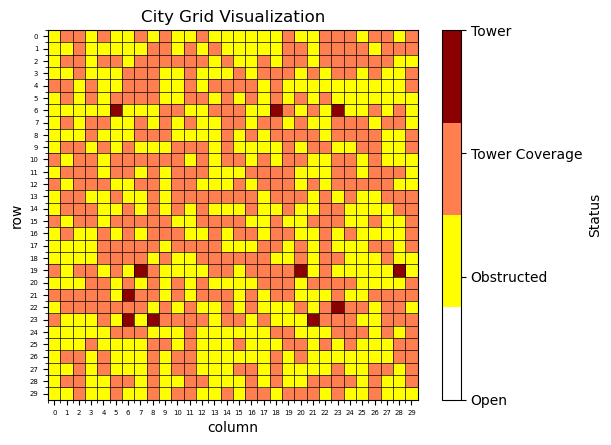

Automatically selected tower cost: 12
Automatically selected budget: 203

The maximum number of towers budget allows: 16

The budget is enough

Optimized city № 1:


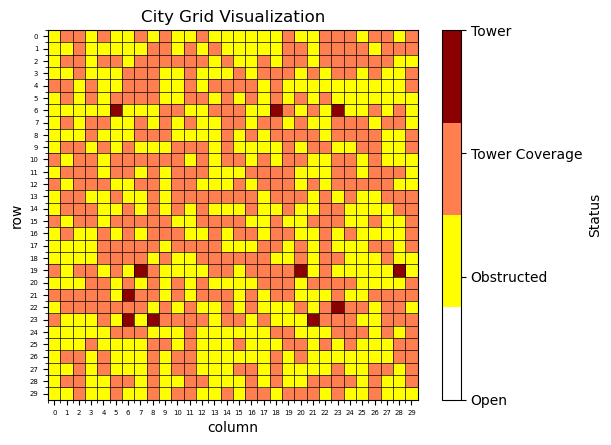

In [14]:
print('City before optimization')
print('Total number of towers is:', len(city.towers))
city.display()

city_optimized = copy.deepcopy(original_city)
city_optimized.towers = copy.deepcopy(city.towers)

CityGrid.optimize_tower_placement_with_limited_budget = optimize_tower_placement_with_limited_budget
tower_cost, budget = set_tower_cost_and_budget(R, auto)
city_optimized.optimize_tower_placement_with_limited_budget(R, tower_cost, budget)
print('\nOptimized city № 1:')
city_optimized.display()

## 2. Consider different types of towers with different ranges and costs. 
How would this change your optimization approach?

In [15]:
class TowerType:
    def __init__(self, R, cost):
        self.range = R
        self.cost = cost
        
def set_tower_cost(tower_range, auto=False):
    if auto:
        tower_cost = random.randint(1, 10)*tower_range
        print('Automatically selected cost is', tower_cost)
    else:
        tower_cost = int(input('Enter tower cost: '))
    return tower_cost
    
def set_budget(tower_types, auto=False):
    min_budget = sum(tower.cost for tower in tower_types)
    if auto:
        # Generate a budget that at least allows you to buy one tower of each type
        budget = random.randint(min_budget, min_budget * 10)
        print('\nAutomatically selected budget is', budget)
    else:
        while True:
            budget = int(input("\nEnter budget: "))
            if budget < 0:
                print("Budget cannot be negative. Please enter a valid budget.")
            elif budget < min_budget:
                print(f"Budget is too low. It should be at least {min_budget} to afford one of each tower type.")
            else:
                break
    return budget

tower_types = []
for i in range(1, 4):  # 3 types of towers
    print('\nTower')
    tower_range = range_input(N, M, auto)
    tower_cost = set_tower_cost(tower_range, auto)
    tower = TowerType(tower_range, tower_cost)
    tower_types.append(tower)
    
tower_types = sorted(tower_types, key=lambda x: x.range / x.cost, reverse=True)

print('\nSorted towers from the most profitable to the less profitable')
for i, tower in enumerate(tower_types, 1):
    print(f'Tower {i}: Range = {tower.range}, Cost = {tower.cost}, Ratio = {round(tower.range / tower.cost, 3)}')
    
budget = set_budget(tower_types, auto)


Tower
Automatically selected range is 3
Automatically selected cost is 6

Tower
Automatically selected range is 5
Automatically selected cost is 45

Tower
Automatically selected range is 5
Automatically selected cost is 10

Sorted towers from the most profitable to the less profitable
Tower 1: Range = 3, Cost = 6, Ratio = 0.5
Tower 2: Range = 5, Cost = 10, Ratio = 0.5
Tower 3: Range = 5, Cost = 45, Ratio = 0.111

Automatically selected budget is 356


In [16]:

def optimize_tower_placement_with_varied_towers(self, tower_types, budget):
    covered = set()
    added_positions = set()
    tower_count = {}
    towers = []
    total_cost = 0

    def calculate_coverage(x, y, R):
        coverage = set()
        for i in range(max(0, x - R), min(self.N, x + R + 1)):
            for j in range(max(0, y - R), min(self.M, y + R + 1)):
                if self.grid[i][j] != 1:
                    coverage.add((i, j))
        return coverage

    def is_coverage_overlapping(coverage):
        # Check if the coverage overlaps with already covered areas
        return not coverage.isdisjoint(covered)
    
    def is_tower_within_city_limits(x, y, R):
        return R <= x <= self.N - R and R <= y <= self.M - R

    def is_too_close(pos1, pos2, range1, range2):
        max_range_half = max(range1, range2) / 2
        distance = max(abs(pos1[0] - pos2[0]), abs(pos1[1] - pos2[1]))
        return distance < max_range_half


    # Fist phase where all towers coverages are in the cite and don't cross each other
    tower_count = {}
    potential_towers = []
    for tower_type in tower_types:
        for i in range(self.N):
            for j in range(self.M):
                if self.grid[i][j] != 1 and (i, j) not in covered:
                    max_coverage = set()
                    best_pos = None
                    for di in range(-tower_type.range, tower_type.range + 1):
                        for dj in range(-tower_type.range, tower_type.range + 1):
                            ni, nj = i + di, j + dj
                            if 0 <= ni < self.N and 0 <= nj < self.M and self.grid[ni][nj] != 1:
                                coverage = calculate_coverage(ni, nj, tower_type.range)
                                if not is_coverage_overlapping(coverage):
                                    uncovered_coverage = coverage - covered
                                    if len(uncovered_coverage) > len(max_coverage) and is_tower_within_city_limits(ni, nj, tower_type.range):
                                        max_coverage = uncovered_coverage
                                        best_pos = (ni, nj)
                    if best_pos and best_pos not in added_positions:  
                        covered.update(max_coverage)
                        potential_towers.append((coverage, best_pos, tower_type))
                        added_positions.add((best_pos, tower_type)) 
        
    # Second phase to find other towers and maximize coverage 
    for tower_type in tower_types:
        for i in range(self.N):
            for j in range(self.M):
                if self.grid[i][j] == 0: 
                    max_coverage = set()
                    best_pos = None
                    coverage = calculate_coverage(i, j, tower_type.range)
                    uncovered_coverage = coverage - covered
                    if len(uncovered_coverage) > len(max_coverage):
                        max_coverage = uncovered_coverage
                        best_pos = (i, j)
                    if best_pos and best_pos not in added_positions:  
                        covered.update(max_coverage)
                        potential_towers.append((coverage, best_pos, tower_type))
                        added_positions.add((best_pos, tower_type)) 
                        

    # Removing overlapping and too closely spaced towers
    for i in range(len(potential_towers) - 1, -1, -1):
        coverage1, pos1, tower_type1 = potential_towers[i]
        for j in range(len(potential_towers) - 1, -1, -1):
            if i != j:
                coverage2, pos2, tower_type2 = potential_towers[j]
                if is_too_close(pos1, pos2, tower_type1.range, tower_type2.range):
                    if len(coverage1 - coverage2) / tower_type1.cost <= len(coverage2 - coverage1) / tower_type2.cost:
                        potential_towers.pop(i)
                        break

    potential_towers.sort(key=lambda x: (len(x[0])/x[2].cost), reverse=True)

    # The choice of towers taking into account the minimization of intersections
    for coverage, pos, tower_type in potential_towers:
        if total_cost + tower_type.cost <= budget:
            towers.append((pos, tower_type))
            covered.update(coverage)
            total_cost += tower_type.cost
            tower_count[(tower_type.range, tower_type.cost)] = tower_count.get((tower_type.range, tower_type.cost), 0) + 1

        
    for key, count in tower_count.items():
        print(f"Tower type (range: {key[0]}, cost: {key[1]}): {count} towers.")

    for pos, tower_type in towers:
        self.place_tower(pos[0], pos[1], tower_type.range)


Tower type (range: 3, cost: 6): 49 towers.

Optimized city № 2:


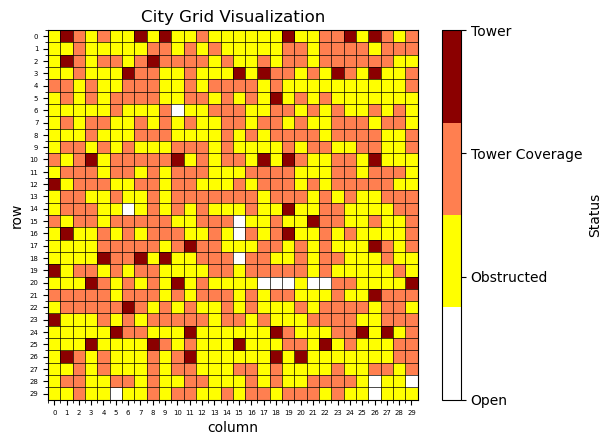

In [17]:
city_optimized_2 = copy.deepcopy(original_city)

CityGrid.optimize_tower_placement_with_varied_towers = optimize_tower_placement_with_varied_towers

city_optimized_2.optimize_tower_placement_with_varied_towers(tower_types, budget)
print('\nOptimized city № 2:')
city_optimized_2.display()